In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import simtk.openmm as mm
from torsionfit import TorsionScanSet as ScanSet
import torsionfit.TorsionFitModel as Model
from torsionfit import sqlite_plus
from pymc import MCMC
from parmed.charmm import CharmmParameterSet
from torsionfit import plots
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

/Users/chayastern/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
param = CharmmParameterSet('../../data/charmm_ff/top_all36_cgenff.rtf',
                           '../../data/charmm_ff/par_all36_cgenff.prm')
structure = '../structure/butane.psf'
scan = '../torsion_scans/DFT_b3lyp/butane_scan_b3lyp_360.log'

In [3]:
# Now calculate MM energy without Dihedrals

butane_scan_no_dih = ScanSet.parse_psi4(scan, structure)
butane_scan_no_dih.compute_energy(param)

In [4]:
# Model and sample. The code was modified to fit the difference potential. 

platform = mm.Platform.getPlatformByName('Reference')

model = Model.TorsionFitModelEliminatePhase(param, butane_scan_no_dih, platform=platform,
                                            param_to_opt=[('CG331', 'CG321', 'CG321', 'CG331')])

sampler = MCMC(model.pymc_parameters, db=sqlite_plus, dbname='diff_pot_mult_on.db', verbose=5)

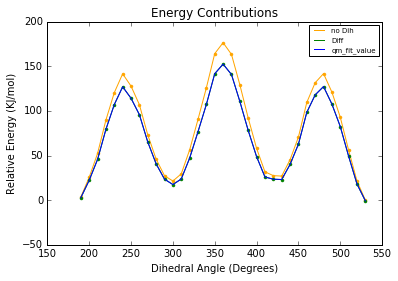

In [6]:
plt.plot(butane_scan_no_dih.steps, butane_scan_no_dih.mm_energy, '.', color='orange')
plt.plot(butane_scan_no_dih.steps, butane_scan_no_dih.mm_energy, color='orange', label='no Dih')

plt.plot(butane_scan_no_dih.steps, butane_scan_no_dih.delta_energy, '.', color='green')
plt.plot(butane_scan_no_dih.steps, butane_scan_no_dih.delta_energy, color='green', label='Diff')

plt.plot(butane_scan_no_dih.steps, sampler.qm_fit.value, label='qm_fit_value')


plt.xlabel('Dihedral Angle (Degrees)')
plt.ylabel('Relative Energy (KJ/mol)')

plt.title('Energy Contributions')
plt.legend(prop={'size':7})
#plt.savefig('Torsion_scan_energy_contribution.pdf

In [7]:
sampler.sample(1000)


Assigning step method Metropolis to stochastic BUTA1_offset
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_2_K
Assigning step method DiscreteMetropolis to stochastic CG331_CG321_CG321_CG331_multiplicity_bitstring
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_3_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_4_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_1_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_6_K
Assigning step method Metropolis to stochastic log_sigma
 [-----------------100%-----------------] 1001 of 1000 complete in 55.9 sec

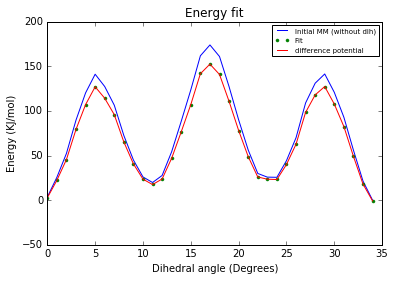

In [8]:
plt.plot(sampler.trace('mm_energy')[0], label='Initial MM (without dih)')
plt.plot(sampler.trace('mm_energy')[-1], '.', color='green', label='Fit')
plt.plot(sampler.qm_fit.value, color='red', label='difference potential')
plt.legend(prop={'size': 7})
plt.title('Energy fit')
plt.xlabel('Dihedral angle (Degrees)')
plt.ylabel('Energy (KJ/mol)')
plt.savefig('Energy_fit_mult_on.pdf')

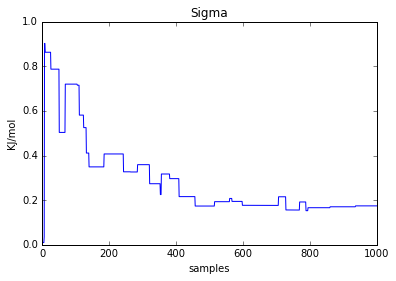

In [9]:
plt.plot(np.exp(sampler.trace('log_sigma')[:]), label='sigma')
plt.xlabel('samples')
plt.ylabel('KJ/mol')
plt.title('Sigma')
plt.savefig('sigma_mult_on.pdf')


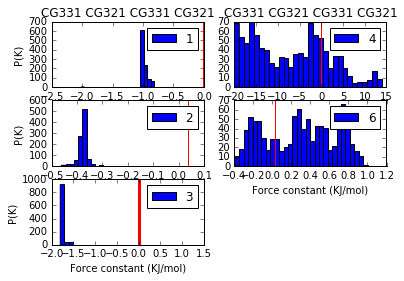

In [10]:
plt.title("CG331 CG321 CG331 CG321")

plt.subplot(3, 2, 1)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_1_K')[:], bins=30, label='1')
plt.axvline(0, color='r', linewidth=3)
plt.legend()
plt.ylabel('P(K)')
plt.title("CG331 CG321 CG331 CG321")

plt.subplot(3, 2, 3)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_2_K')[:], bins=30, label='2')
plt.axvline(0.038, color='r')
plt.legend()
plt.ylabel('P(K)')

plt.subplot(3, 2, 5)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_3_K')[:], bins=30, label='3')
plt.axvline(0, color='r', linewidth=3)
plt.legend()
plt.ylabel('P(K)')
plt.xlabel('Force constant (KJ/mol)')

plt.subplot(3, 2, 2)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_4_K')[:], bins=30, label='4')
plt.title("CG331 CG321 CG331 CG321")
plt.axvline(0, color='r')
plt.legend()

plt.subplot(3, 2, 4)
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_6_K')[:], bins=30, label='6')
plt.axvline(0.032, color='r')
plt.legend()
plt.xlabel('Force constant (KJ/mol)')

plt.savefig('parameter_hist_mult_on.pdf')

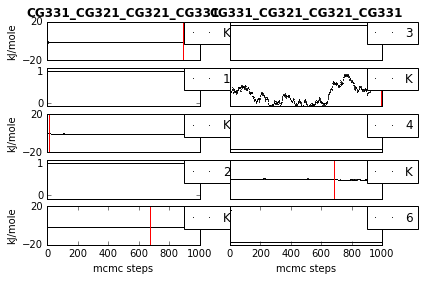

In [11]:
plots.trace_no_phase('CG331_CG321_CG321_CG331', sampler, markersize=1.0)

In [12]:
plots.marg_mult(sampler, 1000, 0, 'mult.png')

TypeError: marg_mult() takes exactly 5 arguments (4 given)

In [13]:
plots.marg_mult?